<a href="https://colab.research.google.com/github/HastingsGreer/SemiSupervisedSequence/blob/master/Downstream_evaluate_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Movies_and_TV_5.json.gz

--2022-08-29 16:20:38--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Movies_and_TV_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791322468 (755M) [application/octet-stream]
Saving to: ‘Movies_and_TV_5.json.gz’

Movies_and_TV_5.jso 100%[===================>] 754.66M  54.7MB/s    in 14s     

2022-08-29 16:20:53 (54.1 MB/s) - ‘Movies_and_TV_5.json.gz’ saved [791322468/791322468]



In [ ]:
!gunzip Movies_and_TV_5.json.gz

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/Movies_and_TV_5.json .

Mounted at /content/drive


In [2]:
pip install --quiet transformers

     |████████████████████████████████| 4.7 MB 7.5 MB/s 
     |████████████████████████████████| 6.6 MB 28.4 MB/s 
     |████████████████████████████████| 120 kB 58.2 MB/s 


In [3]:
import json
text = []
scores = []
with open("Movies_and_TV_5.json", "r") as f:
  for l in f.readlines():
    d = json.loads(l)
    if "reviewText" in d:
      text.append(d["reviewText"])
      scores.append(d["overall"])

In [4]:
from transformers import AutoTokenizer
from transformers import PreTrainedTokenizerFast
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
def tokens(k):
  text_tok = tokenizer(text[10000 * k:10000 * (k + 1)], padding=True, truncation=True, return_tensors="pt")
  text_tok = text_tok['input_ids']
  text_tok = text_tok[:, :128]
  return text_tok, torch.tensor(scores[10000*k:10000 * (k + 1)])

In [7]:
import torch

<All keys matched successfully>

In [22]:
class DownstreamBaselineModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = torch.nn.Embedding(num_embeddings=30522, embedding_dim=32)
    self.hidden_layer = torch.nn.Linear(32, 256)
    self.output = torch.nn.Linear(256, 5)
  def forward(self, input):
    input = self.embedding(input)

    repr = torch.mean(input, axis=1)
    mid = torch.relu(self.hidden_layer(repr))
    return self.output(mid)

task_model = DownstreamBaselineModel()

In [23]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(task_model.parameters(), lr=.001)
curve = []

In [24]:
for k in range(30, 305):
  text_tok, subscores = tokens(k)
  for _ in range(10):
    for _ in range(10):
      optimizer.zero_grad()
      idxs = torch.randint(0, 10000, (64,))
      input_ = text_tok[idxs]

      outputs = task_model(input_)

      l = loss(outputs, subscores[idxs].long() - 1)
      l.backward()
      optimizer.step()
      curve.append(l.item())
    print(torch.mean(torch.tensor(curve[-10:])))

tensor(1.4449)
tensor(1.1898)
tensor(1.2145)
tensor(1.1965)
tensor(1.1888)
tensor(1.1917)
tensor(1.1687)
tensor(1.1971)
tensor(1.1615)
tensor(1.1682)
tensor(1.0363)
tensor(1.0042)
tensor(1.0110)
tensor(0.9926)
tensor(0.9956)
tensor(1.0477)
tensor(1.0740)
tensor(0.9829)
tensor(0.9907)
tensor(1.0027)
tensor(1.0097)
tensor(1.0177)
tensor(1.0508)
tensor(1.0284)
tensor(1.0131)
tensor(1.0421)
tensor(1.0780)
tensor(0.9860)
tensor(1.0779)
tensor(1.0996)
tensor(1.1282)
tensor(1.1857)
tensor(1.1197)
tensor(1.1670)
tensor(1.0438)
tensor(1.1548)
tensor(1.0704)
tensor(1.1197)
tensor(1.1305)
tensor(1.0749)
tensor(1.0248)
tensor(1.0749)
tensor(1.0696)
tensor(1.0466)
tensor(0.9555)
tensor(1.0487)
tensor(1.0685)
tensor(0.9695)
tensor(1.0222)
tensor(1.0789)
tensor(1.0045)
tensor(1.0570)
tensor(1.0432)
tensor(1.0062)
tensor(1.0503)
tensor(1.0506)
tensor(1.0205)
tensor(1.1004)
tensor(1.0315)
tensor(1.0244)
tensor(1.0085)
tensor(1.0024)
tensor(1.0091)
tensor(1.0437)
tensor(0.9319)
tensor(0.9959)
tensor(1.0

ValueError: ignored

(array([[ 1.,  1.,  1.,  3.,  1.],
        [ 1.,  1.,  0.,  0.,  0.],
        [ 0.,  2.,  6.,  2.,  1.],
        [ 0.,  0.,  0.,  3.,  5.],
        [ 0.,  1.,  7.,  8., 20.]]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <matplotlib.collections.QuadMesh at 0x7f31d4fe8050>)

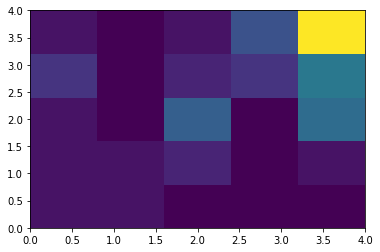

In [26]:
plt.hist2d(torch.argmax(outputs.detach().cpu(), dim=1).numpy(), (subscores[idxs].long() - 1).numpy(), bins=5)

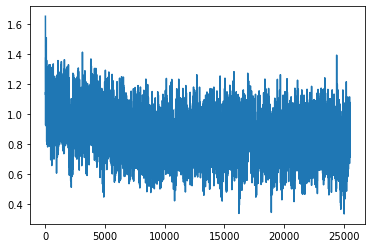

In [25]:
import matplotlib.pyplot as plt
plt.plot(curve)

In [ ]:
tokenizer.decode(input_[46])

In [ ]:
tokenizer.decode(torch.argmax(outputs[46], axis=0))

In [ ]:
import footsteps
torch.save(m.state_dict(), footsteps.output_dir + "weights.pth")
torch.save(curve, footsteps.output_dir + 'learning curve')